In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import contextily as ctx
import os
os.environ['MAXAR_API_KEY']="Y2IzN2FlOTgtODA4OS00NmE0LWI2OGYtMjE1N2VhZGUzZjU5"
import coincident
import geopandas as gpd
from shapely.geometry import box, Polygon

%load_ext autoreload
%autoreload 2

/home/jehayes/mambaforge/envs/helens/lib/python3.11/site-packages/coincident/io/download.py:26: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [5]:
xmin, xmax = 560000, 564800
ymin, ymax = 5.112e6, 5.12e6
bbox = Polygon([
    (xmin, ymin),
    (xmax, ymin),
    (xmax, ymax),
    (xmin, ymax),
    (xmin, ymin)
])
gf_summit = gpd.GeoDataFrame(
    {'geometry': [bbox]}, 
    crs='EPSG:26910'
)

In [3]:
maxar = coincident.datasets.maxar.Stereo()
maxar.area_based_calc = True
maxar

Stereo(alias='maxar', has_stac_api=True, collections=['wv01', 'wv02', 'wv03-vnir', 'ge01'], search='https://api.maxar.com/discovery/v1/search', start='2007-01-01', end=None, type='stereo', provider='maxar', stac_kwargs={'limit': 1000}, area_based_calc=True)

In [13]:
bbox_436 = gf_summit.to_crs(4326).total_bounds

gf_maxar = coincident.search.search(
    dataset=maxar,
    bbox=bbox_436,
    datetime=["2007-01-01", "2024-12-31"],
)

cols = [
    "title",
    "eo:cloud_cover",
    "area:cloud_cover_percentage",
    "view:off_nadir",
    "area:avg_off_nadir_angle",
]
gf_maxar[cols]

,title,eo:cloud_cover,area:cloud_cover_percentage,view:off_nadir,area:avg_off_nadir_angle
1,Maxar WV02 Image 103001010B8C8600,99.157896,99.903938,14.462965,14.444782
2,Maxar WV02 Image 103001010A088600,99.870613,100.000000,30.181137,30.190285
6,Maxar WV01 Image 1020010108CF1A00,82.511206,63.865154,32.677526,32.581440
7,Maxar WV01 Image 1020010109649900,84.441592,67.862109,26.685150,26.736810
14,Maxar WV02 Image 1030010107CFB400,5.187784,0.463185,30.232982,30.217074
...,...,...,...,...,...
333,Maxar WV01 Image 10200100254EB400,0.000000,0.000000,5.428150,5.605305
336,Maxar WV01 Image 102001001DA9CC00,84.947009,56.963083,24.526699,22.763763
337,Maxar WV01 Image 102001001E27C300,83.100320,50.558802,10.947777,11.441594
338,Maxar WV02 Image 103001001CBA2C00,8.080909,0.000000,29.131981,29.046385


In [15]:
gf_maxar = gf_maxar[gf_maxar['area:cloud_cover_percentage'] < 10]

In [16]:
gf_stereo = gf_maxar[gf_maxar['stereo_pair_identifiers'].apply(lambda x: len(x) > 0)].reset_index(drop=True)
gf_stereo['stereo_pair_identifiers'] = gf_stereo['stereo_pair_identifiers'].apply(lambda x: x[0] if len(x) == 1 else x)
gf_stereo_dissolve = gf_stereo.dissolve("stereo_pair_identifiers")

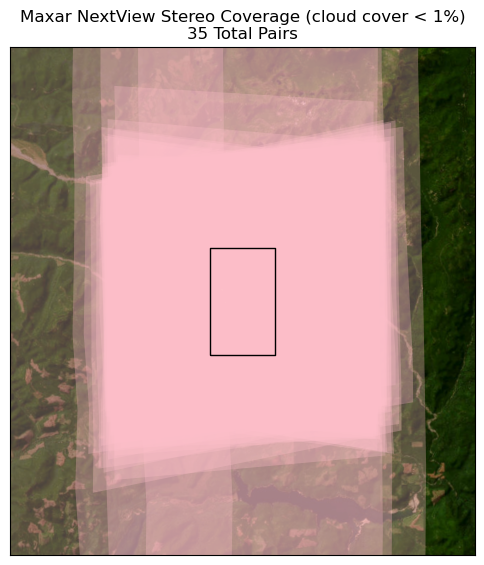

In [17]:
f, ax = plt.subplots(figsize = (6,8))

gf_stereo_dissolve.to_crs(gf_summit.crs).plot(ax=ax, color='pink', alpha=0.3)
gf_summit.plot(ax=ax, facecolor='None', edgecolor='black')

ax.set_xlim(*gf_summit.buffer(15000).total_bounds[[0,2]])
ax.set_ylim(*gf_summit.buffer(15000).total_bounds[[1,3]])

ax.set_aspect('equal')
ax.set(
    xticks=[],
    yticks=[],
    xlabel='',
    ylabel='',
)
ctx.add_basemap(ax=ax, crs=gf_summit.crs, source=ctx.providers.Esri.WorldImagery, attribution=False)
ax.set_title(f"Maxar NextView Stereo Coverage (cloud cover < 1%)\n{len(gf_stereo_dissolve)} Total Pairs");

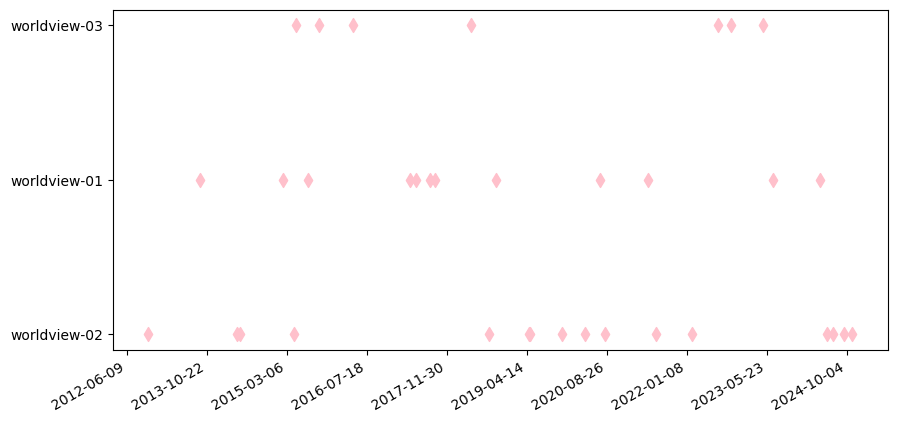

In [18]:
gf_stereo_dissolve["datetime"] = pd.to_datetime(gf_stereo_dissolve["datetime"])
fig, ax = plt.subplots(figsize=(10, 5))
if "constellation" in gf_stereo_dissolve.columns:
    label = gf_stereo_dissolve.constellation.iloc[0]
else:
    label = gf_stereo_dissolve.platform.iloc[0]
plt.scatter(x=gf_stereo_dissolve["datetime"], y=gf_stereo_dissolve["platform"], 
            s=50, marker="d", label=label, c='pink')
ax.xaxis.set_major_locator(plt.MaxNLocator(12))
fig.autofmt_xdate()